In [1]:
import numpy as np
import imageio
import sys
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
imageio.plugins.freeimage.download()
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_normal_collection(normals, label, file, bounds=((None, None), (None, None)), gt_normals=None, vmin=-100, vmax=100, print=False):
    fig, ax = plt.subplots(1, 1)

    normals = normals[normals[:,2] != 0]

    hist, X, Y = np.histogram2d(
          normals[:,0], 
          normals[:,1], bins=(50, 50), range=bounds, density=True)
    
    if gt_normals is not None:
        gt_normals = gt_normals[gt_normals[:,2] != 0]
        gt_hist, _, _ = np.histogram2d(
          gt_normals[:,0], 
          gt_normals[:,1], bins=(50, 50), range=bounds, density=True)
        hist = (hist-gt_hist) #/ (gt_hist+0.01)
    
    pc = ax.pcolormesh(X, Y, hist.T, vmin=vmin, vmax=vmax, zorder=-15)
    cb = plt.colorbar(pc, ax=ax)

    ax.set_xlim(*bounds[0])
    ax.set_ylim(*bounds[1])
    ax.set_facecolor("black")
    ax.grid(False)
    ax.set_title(label)
    ax.set_aspect("equal")
    fig.tight_layout()
    fig.show()

    if(print):
        cb.remove()
        ax.set_rasterization_zorder(-10)
        ax.set_title("")
        ax.set_axis_off()
        fig.tight_layout()
        os.makedirs("print/" + label, exist_ok=True)
        fig.savefig("print/" + label+".pdf", bbox_inches='tight', pad_inches=0, dpi=300)


def plot_normal_collection_1D(normals, label, file, gt_normals=None):
    fig, ax = plt.subplots()

    rbins = np.linspace(-1, 1, 100)

    for n,l in normals:
        z_vals = n[:,2]
        z_vals = np.clip(z_vals,-1, 1)
        hist, bins = np.histogram(z_vals, weights=np.ones_like(z_vals)/(z_vals.shape[0]), bins=rbins, density=False)
        bins = rbins[1:]
        ax.plot(bins, hist, label=l)

    if gt_normals != None:
        z_vals = gt_normals[:,2]
        z_vals = np.clip(z_vals,-1, 1)
        hist, bins = np.histogram(z_vals, weights=np.ones_like(z_vals)/(z_vals.shape[0]), bins=rbins, density=False)
        bins = rbins[1:]
        ax.plot(bins, hist, "--", label="beckmann-smith")


    ax.set_xlim(0,1)
    ax.set_title(label)
    ax.set_xlabel("$n_z$")
    ax.legend()
    ax.set_ylabel("$p(n_z)$")
    fig.tight_layout()

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\dario\AppData\Local\Temp\ipykernel_37660\1170440751.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


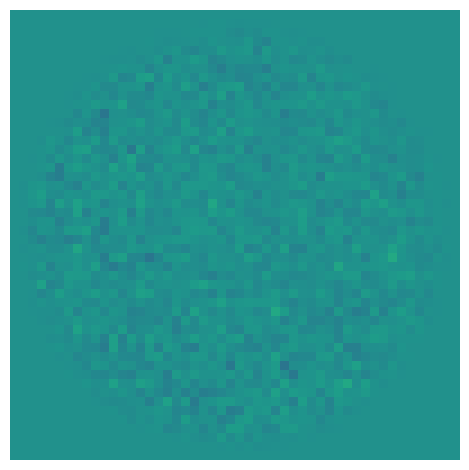

 55%|█████▌    | 11/20 [00:03<00:03,  2.82it/s]

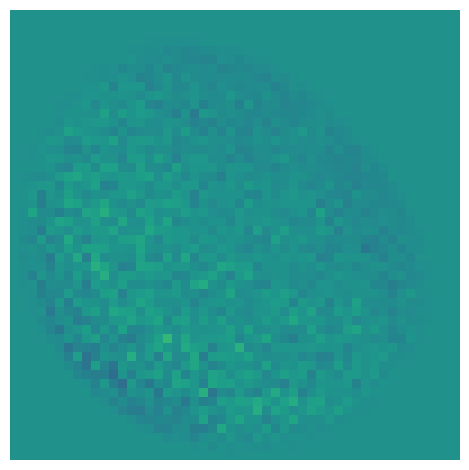

 60%|██████    | 12/20 [00:08<00:07,  1.11it/s]

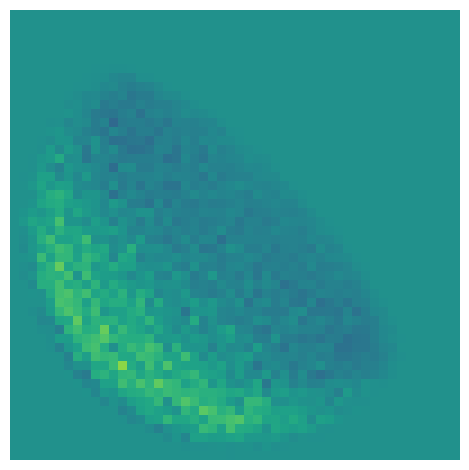

 65%|██████▌   | 13/20 [00:13<00:09,  1.39s/it]

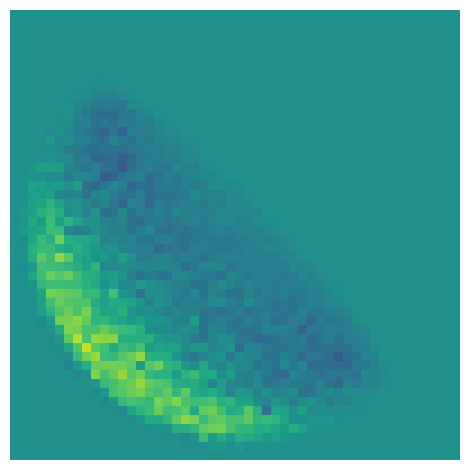

 70%|███████   | 14/20 [00:16<00:10,  1.72s/it]

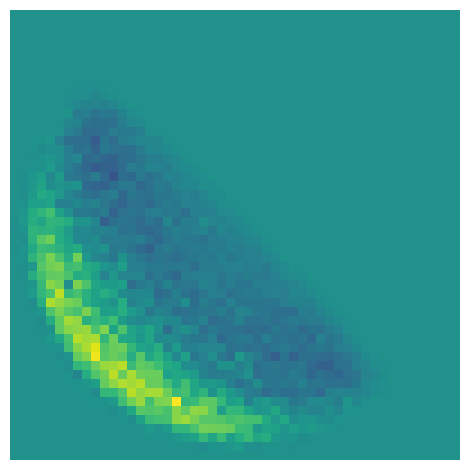

 75%|███████▌  | 15/20 [00:20<00:10,  2.04s/it]

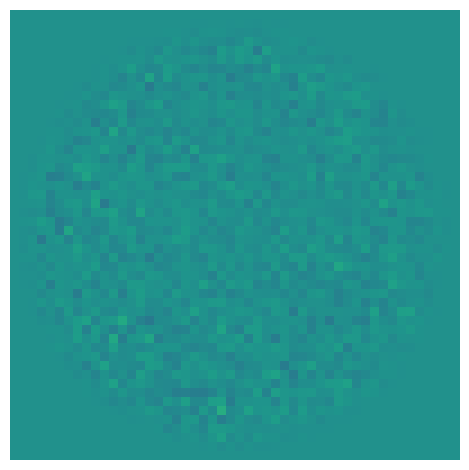

 80%|████████  | 16/20 [00:23<00:09,  2.29s/it]

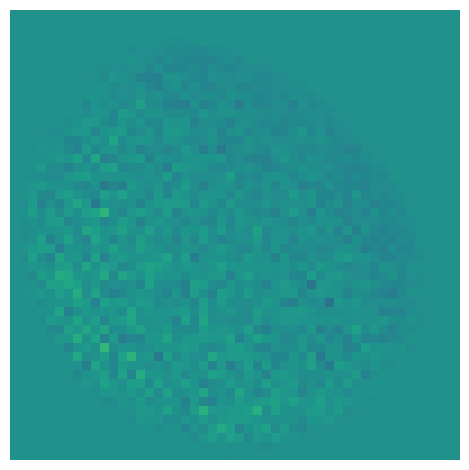

 85%|████████▌ | 17/20 [00:26<00:07,  2.50s/it]

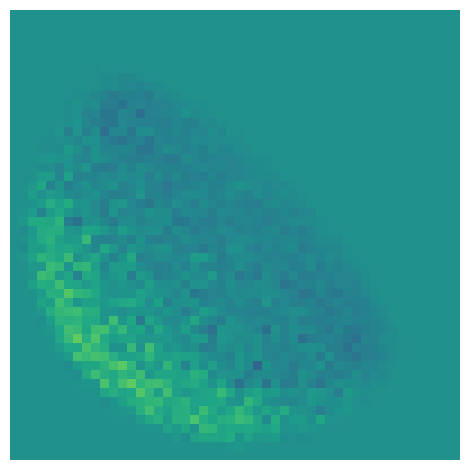

 90%|█████████ | 18/20 [00:27<00:04,  2.05s/it]

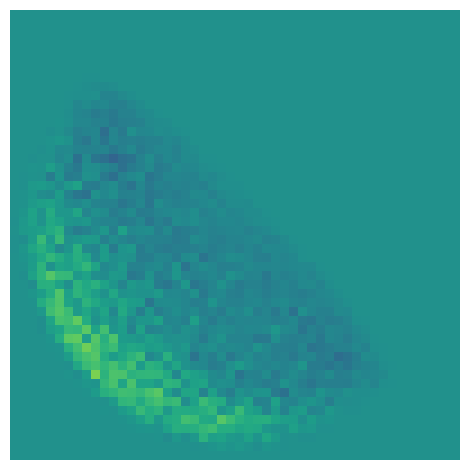

 95%|█████████▌| 19/20 [00:30<00:02,  2.35s/it]

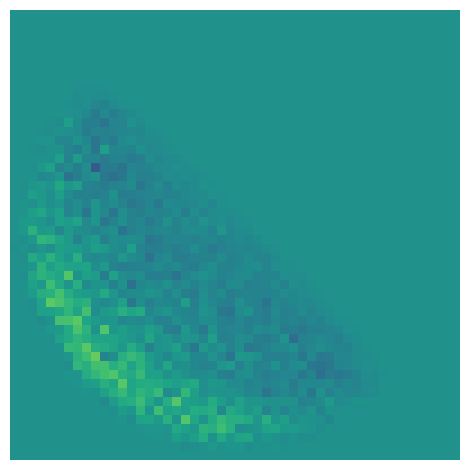

100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


In [3]:

with plt.style.context("seaborn-v0_8-dark"):
    params = {'text.usetex' : True,
            'font.size' : 7,
            'font.family' : 'Linux Libertine'}
    plt.rcParams.update(params)

normal_files = dict()

# for file in tqdm(glob.glob("//dartfs-hpc/rc/lab/J/JaroszLab/dseyb/stimp/normal-gen/function-space/*/*/*85*2048*-normals.bin")+glob.glob("//dartfs-hpc/rc/lab/J/JaroszLab/dseyb/stimp/normal-gen/weight-space/rq/*a=0.1*/*85*-normals.bin")+glob.glob("//dartfs-hpc/rc/lab/J/JaroszLab/dseyb/stimp/normal-gen/weight-space/se/*/*85*-normals.bin")+glob.glob("//dartfs-hpc/rc/lab/J/JaroszLab/dseyb/stimp/normal-gen/beckmann/se/*/*85*-normals.bin")):

for file in tqdm(glob.glob("//dartfs-hpc/rc/lab/J/JaroszLab/dseyb/stimp/normal-gen/*/*/*,0.0000]*/*paper-conv*.bin")):
    normals = np.reshape(np.fromfile(file, dtype=np.float64), (-1,3))#.T

    end_ind = "normals"
    deg_idx = file.find(end_ind)
    deg_idx = deg_idx if deg_idx != -1 else -4

    key = file[:deg_idx+len(end_ind)] + ".bin"
    if key not in normal_files:
        normal_files[key] = []
    normal_files[key].append(normals)

common_prefix = os.path.commonprefix(list(normal_files.keys()))
common_postfix = os.path.commonprefix([k[::-1] for k in list(normal_files.keys())])[::-1]
    
for k, v in tqdm(normal_files.items()):
    if "beckmann" in k:
        continue
    normals = np.concatenate(v, axis=0)

    end_ind = "deg"
    deg_idx = k.find(end_ind)
    beckmann_file = k[:deg_idx+len(end_ind)] + "-normals.bin"
    beckmann_file = beckmann_file.replace("\\", "/")
    beckmann_file = "/".join(beckmann_file.split("/")[:-4]) + "/beckmann/" + beckmann_file.split("/")[-1]

    #beckmann_file = beckmann_file.replace("function-space", "beckmann").replace("weight-space", "beckmann").replace("a=0.500", "a=0.100").replace("a=1.500", "a=0.100").replace("a=10.000", "a=0.100").replace("a=1.000", "a=0.100")

    if beckmann_file not in normal_files:
         gt = np.reshape(np.fromfile(beckmann_file, dtype=np.float64), (-1,3))
    else:
         gt = np.concatenate(normal_files[beckmann_file], axis=0)
    

    plot_normal_collection(normals, k[len(common_prefix):-len(common_postfix)] + " - error", k, bounds = ((-1, 1), (-1, 1)), vmin=-0.25, vmax=0.25, gt_normals=gt, print=True)

    #plot_normal_collection(normals, k[len(common_prefix):-len(common_postfix)], k, bounds = ((-1, 1), (-1, 1)), vmin=0, vmax=2)
    #plot_normal_collection_1D(v, k[len(common_prefix):], k, gt_normals=normal_files[k.replace("-normals", "-normals-beckmann")])

    plt.show()


